# Lab 3 - Convolutional Neural Networks
In this lab we'll implement our first [convolutional neural network](https://en.wikipedia.org/wiki/Convolutional_neural_network) to solve an image classification task.

Our goal today is to predict the value of a handwritten digit, using the very popular [MNIST dataset](http://yann.lecun.com/exdb/mnist/) - a collection of 70,000 grayscale handwritten numbers between 0 and 9.

The steps are pretty much the same as for the previous lab:
 * Acquiring and exploring the dataset
 * Splitting the dataset in train / validation / test partitions
 * Implementing a neural network
 * Writing a training loop
 * Visualising our results
 * Improving the model

There is an excel spreadsheet attached to this that shows you the results that the tutor achieved for the different models he trained. Note there are two sheets in that spreadsheet. One sheet is the tutors results and another blank sheet for you to record your results. Note even the exact same model can produce different results due to random weight initialisations. So don't be too stressed if you do not get exactly the same results as the tutor.


There is also a text file showing the minimum training code necessary to train MNIST. It is interesting to take a look at how small you can make the training loop.

## Data Acquisition
As usual, the first step is to acquire the dataset. The data format for MNIST is notoriously complex, so we'll use a [pre-processed version](https://ashwhall.github.io/download/mnist_csv/readme.txt). The CSV file is in a compressed zip file, which [Pandas](https://pandas.pydata.org/) is able to decompress and read.

In the next cell Pandas will download the dataset and store it in a `DataFrame` object. MNIST is already partitioned into training and test splits, so we'll download each of the files and store them in their own `DataFrame`. We also want a validation partition, so we'll be splitting the training data further into a training partition and a validation partition.

In [ ]:
import pandas as pd

# Download train/val data
print("Downloading training/validation dataset... ", end='')
trainval_df = pd.read_csv("https://ashwhall.github.io/download/mnist_csv/mnist_train.zip", header=None)
print("done.")

# Download test data
print("Downloading training/validation dataset... ", end='')
test_df = pd.read_csv("https://ashwhall.github.io/download/mnist_csv/mnist_test.zip", header=None)
print("done.")

### Check for Missing Data
Like we did in the previous lab, we'll check for any missing data before going any further.

Last time, we used `some_df.isnull().sum()` to get the number of null values in each column. As this dataset has hundreds of columns, printing it this way would result in printing hundreds of numbers to the console - which is not very easy to read. \
To avoid this, we'll we'll sum the result of that sum - thus summing the number of null values in each column to produce a single value. 

*This dataset doesn't contain any null values, so we don't need to fix it. Common strategies include replacing nulls with the mean value for that attribute, the value zero, or just deleting the entire example.*

In [ ]:
print("Train/val nulls: ", trainval_df.isnull().sum().sum())
print("Test nulls:      ", test_df.isnull().sum().sum())

Train/val nulls:  0
Test nulls:       0


## Partition the Dataset
Now we'll split our dataset into three partitions - training, validation and testing like we did last time. The test partition has already been provided for us, so all that's left is splitting the `trainval_df` into training and validation `DataFrames`.

To do this split, we'll use the handy `DataFrame.sample` function, which returns a randomly sampled percentage of the `DataFrame`.

In [ ]:
# Sample the train examples
train_df = trainval_df.sample(frac=0.8, random_state=42)
# Use 'drop' to take what's left
val_df = trainval_df.drop(train_df.index)

print("Train DataFrame:     ", train_df.shape)
print("Validation DataFrame:", val_df.shape)
print("Test DataFrame:      ", test_df.shape)

Train DataFrame:      (48000, 785)
Validation DataFrame: (12000, 785)
Test DataFrame:       (10000, 785)


The previous cell tells us how many examples are in each dataframe and how many columns each example has. We're working with images but each example is a list of 785 numbers - how does that work?

The [download page](https://pjreddie.com/projects/mnist-in-csv/) of our dataset states that the data format is `label, pix-11, pix-12, pix-13, ...`. \
This means that the first column in the dataset is the numerical value of the digit, and the remaining 784 columns are the pixel values. So the images are 28 pixels wide and 28 pixels tall.

Let's look at that for ourselves

In [ ]:
train_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784
12628,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
37730,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
39991,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8525,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8279,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Sure enough, the first column is a number between 0 and 9, and the remaining values are miscellaneous numbers. The pixel values are mostly `0` as the images have a black background with white text.

Now we just need to convert the pixel data into 2D images and separate the labels from the images.


In [ ]:
import numpy as np

# A utility function to extract the labels and images from a dataframe
def extract_images_labels(df):
    # Extract the first column values as labels
    labels = np.array(df.iloc[:, 0])

    # Extract the remaining columns as images
    images = np.array(df.iloc[:, 1:])

    # Reshape the images and convert to floats
    images = images.reshape(-1, 28, 28, 1).astype(np.float32)

    return images, labels

# Perform the extraction on each of the DataFrames
train_images, train_labels = extract_images_labels(train_df)
val_images, val_labels = extract_images_labels(val_df)
test_images, test_labels = extract_images_labels(test_df)

print("Train image shape:", train_images.shape)

Train image shape: (48000, 28, 28, 1)


Each image now has a shape of `(28, 28, 1)` - `28` pixels tall, `28` pixels wide, and a single (grayscale) colour channel - perfect!

## Data Exploration

### View Some Examples
Now that we have the data in the correct format, we can finally look at the images!

As we may want to do this later, we'll use a utility function which prints some images with their associated labels. This function is a little complex as we want to support a couple of different formats, so it's been written for you.

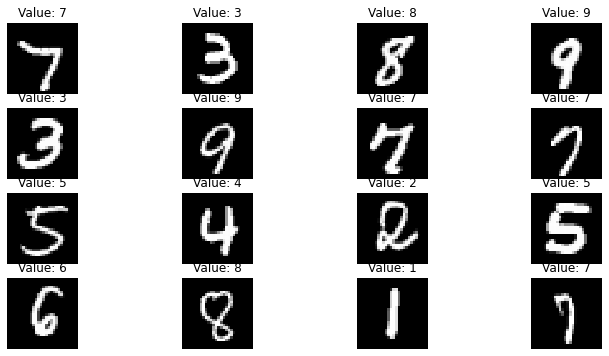

In [ ]:
# Import a graph-plotting library
import matplotlib.pyplot as plt

# This function takes a list of images and a list of labels and plots the first n_images
def plot_some_images(images, labels, n_images=16):
    # Set the figure size
    plt.figure(figsize=(12, 6))

    for i in range(n_images):
        # Select a subplot in a grid
        plt.subplot(4, 4, i + 1)
        img = images[i]
        # Select the channel dimension, depending on data format
        img = img[0] if img.shape[0] == 1 else img[..., 0]

        # Plot the image with title and no axis ticks
        plt.imshow(img, cmap='gray', interpolation='nearest')
        plt.title(f"Value: {labels[i]}")
        plt.axis('off')
    plt.show()

# Plot some training images and labels - feel free to display the validation and
# test images instead
plot_some_images(train_images, train_labels)

### Plot Class Distributions
Now we've seen some examples from the dataset, let's take a look at the distribution of values. We'll use a histogram like last time, and will plot a different one for each of the training / validation / testing splits.

We are primarily looking for two things in these plots:
1. That there's an approximately equal number of examples for each label.
 * For this to be true, the bars should all have approximately the same height. A 10-20% difference in height shouldn't be a problem. This issue is called *class imbalance*, and there are a number of techniques to handle it.
2. That the distribution between the three partitions are approximately equal.
 * The graphs should look roughly the same - if there's a discrepancy between the partitions, we would need to repartition, possibly using [Stratified Sampling](https://en.wikipedia.org/wiki/Stratified_sampling).


Lucky for us, our dataset has none of these problems!

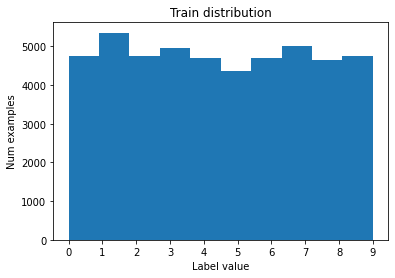

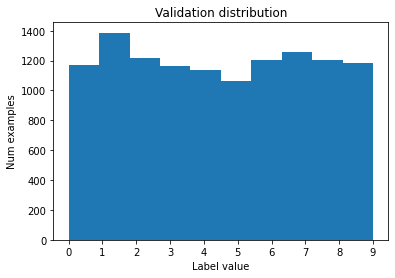

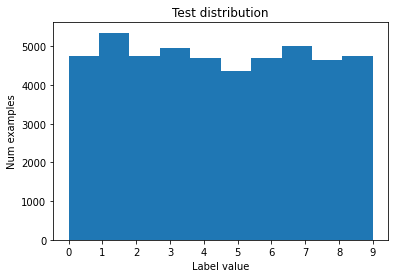

In [ ]:
def plot_label_distribution(labels, split):
    # Plot a histogram with the given title
    plt.title(f"{split} distribution")
    plt.hist(labels, bins=10)
    # Label the axes
    plt.xlabel("Label value")
    plt.ylabel("Num examples")
    # Add the class labels along the x axis
    plt.xticks(range(10))
    plt.show()

# Plot the distribution of each partition
plot_label_distribution(train_labels, "Train")
plot_label_distribution(val_labels, "Validation")
plot_label_distribution(train_labels, "Test")

## Create the Datasets and DataLoaders
In the previous lab we used PyTorch's `TensorDataset`, which is great for generic tabular data. However you'll often require custom behaviour from your dataset, which makes writing your own dataset class a great idea. First take a look at a very simple example of how to write a pytorch dataset class in lecture 2.

<font color='red'>In the next cell, write a basic Dataset class which just implements the required methods</font>:
 * `__init__`: initialises Dataset
 * `__len__`: returns the number of examples in the dataset
 * `__getitem__`: returns the input data and label for a specific index

In [ ]:
# Import the base class
from torch.utils.data import Dataset

# Subclassing in Python just requires adding the class name in parentheses
class MNISTDataset(Dataset):
    # The __init__ method is similar to a constructor like you find in other
    # languages. We will take three arguments:
    #  - images: the numpy array of all images for this dataset
    #  - labels: the numpy array of labels for our images
  
    def __init__(self, images, labels):
        # TODO: Store the images and labels as member variables
        #       self.images and self.labels respectively.
        
        # SOLUTION LINE
        self.images = images
        self.labels = labels
   

    def __len__(self):
        # TODO: Return the length (number of images) of the dataset
        # SOLUTION LINE
        return len(self.labels)

    def __getitem__(self, idx):
        # TODO: Store in image and label for the particular image and corresponding label
        #       at index idx. Get these from the member variables you initialized in _init_
        # image = ...
        # label = ...
        
        # SOLUTION LINE
        image = self.images[idx]
        # SOLUTION LINE
        label = self.labels[idx]

        return image, label

Now we can initialise an MNISTDataset for each of our train, valdiation and test partitions.

<font color='red'>Update the next cell to initialise three MNISTDataset objects, one for each of the training, validation, and test partitions.</font>

In [ ]:

# This line constructs the train_dataset object using the training images, labels
# and image transforms. 
train_dataset = MNISTDataset(train_images,
                             train_labels)

# TODO: Instantiate the val and test MNISTDataset objects with the correct arguments

# val_dataset = ...
# test_dataset = ...


# SOLUTION LINE
val_dataset = MNISTDataset(val_images,
                           val_labels)
# SOLUTION LINE
test_dataset = MNISTDataset(test_images,
                            test_labels)

Now lets take our newly created datasets for a spin! Get the first element of the training dataset and display it.

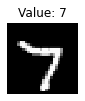

In [ ]:
#TODO: store in the variable first_training_image the first image from the training dataset.
# first_training_image, first_training_label = 

# solution 
first_training_image, first_training_label = train_dataset[0]

# display the first training example
images= [first_training_image]
labels = [first_training_label]
plot_some_images(images, labels, 1)

Almost there! We have Dataset objects and now we just need to create DataLoaders. Recall that a [DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) is used to shuffle data and gather it into batches, so all we need to provide as arguments are the `Dataset`, batch size, and a boolean of whether we want to shuffle the data.

<font color='red'>Update the next cell to initialise three DataLoader objects, one for each of the training, validation, and test Datasets.

In [ ]:
from torch.utils.data import DataLoader

BATCH_SIZE = 64

# Create the train dataloader using the train_dataset
# Note we ask the data loader to randomly suffle the data when loading them.
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# TODO: Create the val and test dataloaders.
# val_loader = ...
# test_loader = ...


# SOLUTION LINE
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
# SOLUTION LINE
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Now that we have a dataloader setup. Lets try to display the first 16 images in the first training batch.

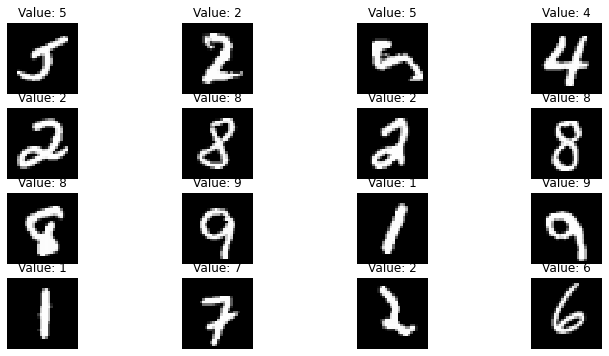

In [ ]:
for batch in train_loader:
  images, labels = batch  
  plot_some_images(images, labels, 16)
  break


Lets now inspect the shape of the input data and see if it is what we want.

In [ ]:
for batch in train_loader:
  images, labels = batch  
  print("images shape: ", images.shape)
  print("labels shape: ", labels.shape)
  break

images shape:  torch.Size([64, 28, 28, 1])
labels shape:  torch.Size([64])


The image shape of \[64, 28, 28, 1\] maps to \[ batch size = 64, height = 28, width = 28, number of channels = 1\]. The images have a single channel since it is just black and white. Turns out this is not the shape we want. Convolutional layers in pytorch expect the input to be shape \[ batch size, number of channels, height, width\]. So we need to end up with shape \[64, 1, 28, 28\]   How can make the data the right shape? We could try reshape. But that would give us the wrong answer since reshape just reinterprets the same piece of memory in a different way. We actually have to move stuff around so that the number of channels dimension is moved from the 4th dimension to the 2nd dimension. We need to transpose the data. Take a look at the transpose slide in lecture 2 to see how you can do that. There it shows how to use the permute function pytorch to transpose the data. Then test it in the cell below. 

In [ ]:
for batch in train_loader:
  images, labels = batch  
  
  # TODO: write code to transpose images so their shape become  [64, 1, 28, 28]
  # images = ...

  # SOLUTION LINE
  images = images.permute(0,3,1,2)

  print("images shape: ", images.shape)
  break



images shape:  torch.Size([64, 1, 28, 28])


## Set Up for Training
That's the end of data loading, so now we can move on to the fun stuff!

### Enable GPU Training *(if available)*
We'll use the same code as last time to use the GPU for training if possible.

In [ ]:
import torch
# By default we'll assume that GPU acceleration isn't available
device = torch.device("cpu")

# Check if GPU acceleration is available (requires a CUDA-compatible GPU) and
# set the device variable accordingly. If the computer has more than one GPU,
# you can specify which one by replacing 0 with a different index
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)

print("Training on", device)

Training on cuda:0


### Define the Model
We'll start with a basic Multilayer Perceptron like last lab before building more complex models a little later. The MLP has been partially implemented for you.

#### Multilayer Perceptron

As we're dealing with image data instead of tabular data, the input shape is incompatible with MLPs - they expect the inputs to be shaped `[batch_size, n]`, where `n` is the size of some feature vector. \
To make our image data fit this description, we will combine the last three dimensions of the image data: \
`[batch_size, num_channels, height, width] => [batch_size, num_channels*height*width]`.

Lucky for us, PyTorch has a built in module for this:

**nn.Flatten** \
This module takes a tensor of any shape, and flattens it so that it's appropriate for a linear layer. It takes no arguments.

Let's look at an example before moving on:

In [ ]:
import torch.nn as nn

# Create some fake data - a batch of 2 images with 1 channel, height and width both 28 pixels
dummy_data = torch.ones(2, 1, 28, 28)
print(dummy_data.shape)

# Create a flatten layer to combine the last three dimensions
my_flatten = nn.Flatten()

# Pass the images through the flatten layer
flattened = my_flatten(dummy_data)

print(flattened.shape)

torch.Size([2, 1, 28, 28])
torch.Size([2, 784])


The last three dimensions have been combined, so the output shape is `[2, 1 * 28 * 28] => [2, 784]`

Next up, the model. Write an MLP model that takes input of the following shape \[batch size, number of channels =1, height = 28, width = 28\] it then puts the data into the following layers:

1.   Flatten the tensor
2.   Linear layer that outputs 32 neurons
3.   ReLU
4.   Linear layer that outputs `output_size` neurons



In [ ]:
# Custom models need to subclass nn.Module
class MLP(nn.Module):
    def __init__(self,
                 device,
                 input_size=1*28*28, # default to num_channels * height * width
                 output_size=10      # default to the number of classes
                 ):
        super().__init__()

        # Write the classifier layers here.
        self.seq = nn.Sequential(
            
            ## TODO: add the following layers
            #        Flatten the tensor
            #        Linear layer that outputs 32 neurons
            #        ReLU
            #        Linear layer that outputs output_size neurons

            # Solution
            nn.Flatten(),
            nn.Linear(input_size, 32),
            nn.ReLU(),
            nn.Linear(32, output_size)
        )
        # Transfer the model weights to the GPU
        self.to(device)
    
    # The forward method takes input values and returns predictions. We just need
    # to pass the inputs through the layers we defined in __init__
    def forward(self, x):
        return self.seq(x)

We'll build more interesting models a bit later, even with such a simple model you should expect a test accuracy of almost 95%. 

#Simple Train, Validation and Test Loop
We make some small changes to the simple training and test loop that we used for lab02b here. This time lets plot the learning curve and accuracy using something nice instead of just printing it all on the screen. We will use tensorboard to plot the learning curves instead.
The way we use tensorboard is to first write a log of the values we want to monitor into a file. Then we use tensorboard to display the contents of the log files. Each time we re-run the training loop we attach a different time stamp to the log file. This way we can separate the different runs from each other. 

To look at log files or delete the log files, click on the folder icon on the left pane of this notebook.
If you ever want to delete **all** the log files at once you can use the following command: *!rm -rf logs*.  You can find this code in the last cell of the notebook.

In [ ]:
pip install torchmetrics

     |████████████████████████████████| 397 kB 12.1 MB/s 


In [ ]:
# tqdm can be used to print a nice progress bar during training
from tqdm.notebook import tqdm
from datetime import datetime
import torchmetrics
from torch.utils.tensorboard import SummaryWriter
import torch.optim as optim

# TODO: change exp_name whenever you try a different model or change 
#       something in your model. It is used for tensorboard logging.
exp_name = "MLP version 1"

# The SummaryWriter requires a directory path to write logs. We will construct a
# string using the exp_name and a date attached to the end. This way if we run the
# same experiment twice it will be listed separate on tensorboard.
log_name = "logs/" + exp_name + f" {datetime.now()}"
print("Tensorboard logs will be written to:", log_name)
writer = SummaryWriter(log_name)

criterion = nn.CrossEntropyLoss()

# Use MLP as the model
model = MLP(device)

# Use the Adam optimizer with initial learning rate set to 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

#initialize metric
train_accuracy = torchmetrics.Accuracy().to(device)
val_accuracy = torchmetrics.Accuracy().to(device)

# The number of times we loop over the entire dataset
num_epochs = 10

for epoch in tqdm(range(num_epochs)):

    # The following is computed for every complete pass through the dataset
    epoch_train_loss = 0.0
    epoch_accuracy = 0.0

    for data in train_loader:
        
        images, labels = data
        images, labels = images.to(device), labels.to(device)

        #TODO: take the permute code you wrote in one of the early cells and use
        #      it here to permute the images tensor so that it has the right shape of [64, 1, 28, 28]
        #      images = ...
        
        images = images.permute(0,3,1,2)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward
        outputs = model(images)

        # Compute the loss using the loss function
        loss = criterion(outputs, labels)
        epoch_train_loss += loss.item()

        # Perform backprop using the loss
        loss.backward()
        optimizer.step()

        # Calculate accuracy for this batch
        acc = train_accuracy(outputs, labels)

    # adds the training loss and accuracy to tensorboard
    writer.add_scalar("Loss/training", epoch_train_loss, epoch)
    writer.add_scalar("Accuracy/training", train_accuracy.compute(), epoch)

    # print training statistics
    print('epoch: %d loss: %.3f' % (epoch + 1, epoch_train_loss / len(train_loader)))
    print('epoch: %d accuracy: %.3f' % (epoch + 1, train_accuracy.compute()))

    # reset for the next epoch
    train_accuracy.reset()
    # The code below computes the validation results
    for data in val_loader:
          images, labels = data
          images, labels = images.to(device), labels.to(device)

          # TODO: need to put the permute function call here too.
          images = images.permute(0,3,1,2)

          # Put the model into eval mode and disable gradient calculations
          model.eval()
          with torch.no_grad():
              # Perform inference on the current batch of inputs
              outputs = model(images)

          acc = val_accuracy(outputs, labels)
    # adds the validation accuracy to tensorboard
    writer.add_scalar("Accuracy/validation", val_accuracy.compute(), epoch)
    # reset for the next epoch
    val_accuracy.reset()

print("finished training")
test_accuracy = torchmetrics.Accuracy().to(device)
test_inputs = []
test_predictions = []
test_targets = []
# We can compute the final test accuracy here
for data in test_loader:
  images, labels = data
  images, labels = images.to(device), labels.to(device)

  test_inputs.extend(images.detach().cpu().numpy())
  test_targets.extend(labels.detach().cpu().numpy())

  # TODO: need to put the permute function call here too.
  images = images.permute(0,3,1,2)

  # Put the model into eval mode and disable gradient calculations
  model.eval()
  with torch.no_grad():
      # Perform inference on the current batch of inputs
      outputs = model(images)
      test_predictions.extend(outputs.detach().cpu().numpy())

  acc = test_accuracy(outputs, labels)

# Convert class prediction scores to the digits they correspond
test_predictions = np.argmax(test_predictions, 1)
test_inputs = np.array(test_inputs)
print("The final test accuracy is: ", test_accuracy.compute())

# reset internal state to make the metric ready for new data
test_accuracy.reset()


Tensorboard logs will be written to: logs/MLP version 1 2022-03-23 00:49:07.233834


  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 1 loss: 2.522
epoch: 1 accuracy: 0.556
epoch: 2 loss: 0.675
epoch: 2 accuracy: 0.808
epoch: 3 loss: 0.486
epoch: 3 accuracy: 0.868
epoch: 4 loss: 0.396
epoch: 4 accuracy: 0.893
epoch: 5 loss: 0.339
epoch: 5 accuracy: 0.908
epoch: 6 loss: 0.298
epoch: 6 accuracy: 0.919
epoch: 7 loss: 0.263
epoch: 7 accuracy: 0.928
epoch: 8 loss: 0.235
epoch: 8 accuracy: 0.935
epoch: 9 loss: 0.211
epoch: 9 accuracy: 0.941
epoch: 10 loss: 0.190
epoch: 10 accuracy: 0.946
finished training
The final test accuracy is:  tensor(0.9391, device='cuda:0')


## Tensorboard

The code below will launch tensorboard so you can see the history of your training. You can reuse this cell whenever you want to view the effects of your training. You may need to press the refresh button on tensorboard to see it. The tensorboard refresh is often quite slow, so you may need to wait some time before the log values get reflected in tensorboard.




In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs

### Visualise the Results
We won't do much visualisation, just display some images along with the classes that the model predicted. Run the next cell to see that.

#### Model Predictions

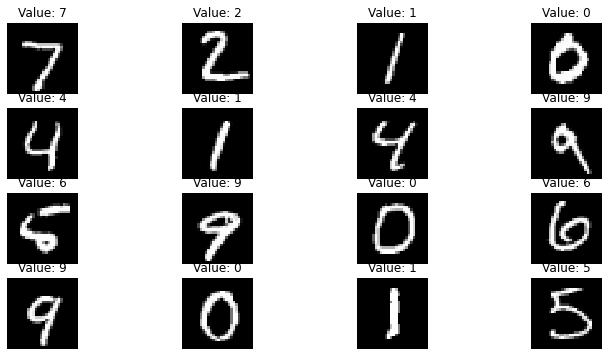

In [ ]:
plot_some_images(test_inputs, test_predictions)

### Incorrect Model Predictions

Sure, it does a great job, but it's probably more interesting to see which examples it got wrong. We'll look at that in the next cell.

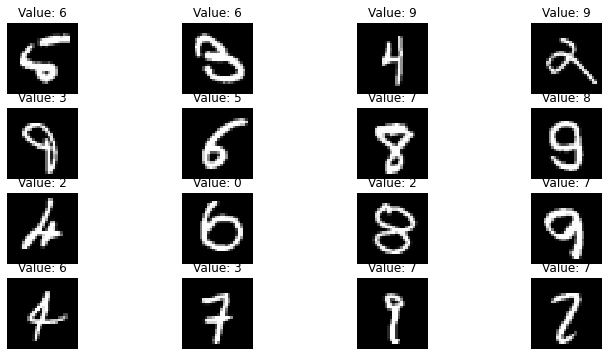

In [ ]:
# Get the indices of the examples the model predicted incorrectly
incorrect_pred_indices = np.where(np.not_equal(test_predictions, test_targets))
# Extract the incorrectly predicted images and what number the model thought they were
incorrectly_predicted_images = test_inputs[incorrect_pred_indices]
incorrectly_predicted_labels = test_predictions[incorrect_pred_indices]

plot_some_images(incorrectly_predicted_images, incorrectly_predicted_labels)

## Implement More Models
The rest of the lab will be spent implementing different models, then training and observing the results. After implementing each model, return to the "Train the Model" section and replace the `model = ...` line with your new model class and renaming your experiment by setting `exp_name = ...` to reflect the new model before re-training.

#### Convolutional Network

The MLP we built does quite a good job, but it's not really appropriate for our task. We usually use 2D convolutions when performing image-based tasks, so we'll now implement that! Before we actually write the model, we need to quickly learn a bit about the new layers we plan on using.

**nn.Conv2d** \
This function creates a 2D convolution layer, and requires three arguments:
 * `in_channels` - the number of channels in the input
 * `out_channels` - the number of channels to output - we can make this value whatever we like.
 * `kernel_size` - the size of the convolution kernel - we usually use `3`

In [ ]:
# We'll use the same dummy data that we used before.
dummy_data = torch.ones(2, 1, 28, 28)
print(dummy_data.shape)

# Create a 2d-conv layer that takes 1 input channel and outputs 4 channels using a 3x3 kernel
my_conv = nn.Conv2d(1, 4, 3)

# Pass the images through the conv layer
convolved = my_conv(dummy_data)

print(convolved.shape)

torch.Size([2, 1, 28, 28])
torch.Size([2, 4, 26, 26])


Take a moment to look at the shapes.

The number of channels changed from 1 to 4, matching the arguments we provided to the convolution layer.

The image height and width changed from 28 to 26, as we didn't apply any padding to the conv layer.

We can specify the amount of padding to apply, by providing the `padding` argument:

In [ ]:
# Create a 2d-conv layer that maps from 1 channel to 4 channels with a 3x3 kernel
# with padding of 1 pixel
my_conv = nn.Conv2d(1, 4, 3, padding=1)

# Pass the images through the conv layer
convolved = my_conv(dummy_data)

# Now the output height/width will be the same as the input
print(convolved.shape)

torch.Size([2, 4, 28, 28])


When we use multiple convolution layers, we can choose any number of output channels, we just need to make sure that the number input channels matches on the following layer. E.g.

```python
# 1 input feature map goes to 4 output feature map
my_conv1 = nn.Conv2d(1, 4, 3)
# 4 input feature map goes to 8 output feature map
my_conv2 = nn.Conv2d(4, 8, 3)
# 8 input feature map goes to 16 output feature map
my_conv3 = nn.Conv2d(8, 16, 3)
# 16 input feature map goes to 20 output feature map
my_conv4 = nn.Conv2d(16, 20, 3)
```
Note how the number of input channels for each conv layer matches the previous output.

**nn.MaxPool2d** \
This module performs *spatial* max pooling.  It only requires a single argument - the kernel size. If we provide a kernel size of `2`, the height and width of the outputs will be half of the inputs.  This means the operator takes a 2 x 2 block of input values and returns a single max value. So you can see the height and width dimensions go from 28 to 14.

In [ ]:
# Create a max pool layer with a 2x2 kernel
my_pool = nn.MaxPool2d(2)

print(dummy_data.shape)

# Apply the layer to our dummy data
pooled = my_pool(dummy_data)

print(pooled.shape)

torch.Size([2, 1, 28, 28])
torch.Size([2, 1, 14, 14])


Cool, let's get to work building the model. One of the nice things about how PyTorch handles models is that we can build models composed of models. We're going to take advantage of this, and re-use the MLP from earlier.

In a moment, you'll complete the implementation of the ConvNet class.
We will stack some 2D convolution layers to extract image features from the inputs - this is known as a *feature extractor*. We will then provide those features as inputs to the MLP from earlier to make class predictions.

<font color='red'>In the next cell, complete the implementation of the ConvNet class.</font> \
This will require a few steps:

**The `__init__` method:**
 1. Initialise a `Sequential` module with the following layers:
  * Conv2D mapping to 8 channels, with a kernel size of 3, no padding
  * ReLU activation function
  * MaxPool2D with a kernel size of 2
 1. Initialise an `MLP` module (that we defined earlier)

**The `forward` method:**
 1. Pass the inputs through the feature extractor
 1. Pass the outputs from step 1 through the MLP and return them


In [ ]:
class ConvNet(nn.Module):
    def __init__(self, device):
        super().__init__()
        # TODO 1: Initialise a Sequential module
        # self.feature_extractor = nn.Sequential(...
        # SOLUTION LINE
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(1, 8, 3),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        # TODO 2: Initialise an MLP module
        # self.mlp = MLP(...
        self.mlp = MLP(device, 1352)

        # Transfer the model weights to the GPU
        self.to(device)
    
    # The forward method takes input values and returns predictions. We just need
    # to pass the inputs through the layers we defined in __init__
    def forward(self, x):
        # TODO 1: Pass the inputs through the feature extractor
        # features = ...
        features = self.feature_extractor(x)
        #print("features shape:", features.shape)

        # TODO 2: Pass the inputs through the MLP
        # return ...
        return self.mlp(features)

Before going anywhere, let's see what happens when we pass some dummy data through the model.

<font color='red'>Run the next cell and see what happens</font>

In [ ]:
# Construct the model
net = ConvNet(device)

# Try passing our dummy data through the model. We need to transfer the dummy
# data to the GPU for it to work
net(dummy_data.to(device))

# The shape will be [2, batch, height, width], so we'll need to set the MLP input
# size to be batch * height * width

tensor([[-0.0198, -0.1830, -0.1276,  0.0068,  0.1504,  0.0073, -0.1231, -0.1746,
          0.1133, -0.0102],
        [-0.0198, -0.1830, -0.1276,  0.0068,  0.1504,  0.0073, -0.1231, -0.1746,
          0.1133, -0.0102]], device='cuda:0', grad_fn=<AddmmBackward>)

**The model crashes!** This is because we didn't correctly set the input size to our MLP. It is still assuming that the input size is `1*28*28`, but because we put the images through some conv layers, this is no longer true.

Although it's possible to calculate the size of `features`, it's easier to just print out its shape then update our code accordingly.

<font color='red'>Uncomment the line which prints out the `features.shape` in the `forward` function of the `ConvNet` class, then re-run the above cell.</font>

When you run the cell again, you'll see the shape printed is `[2, 8, 13, 13]`, meaning that the input size of the MLP should actually be `8 * 13 * 13 = 1352`.
Update the MLP initialisation to use this value, then re-run the above cell. It shouldn't crash!

<font color='red'>When you're satisfied that you've fixed the above problem, comment out the line which prints out the features.shape in the forward function of the ConvNet class.</font> \
*We don't want it printing something every time the model makes a prediction!*

Once that's done, return to the "Train the Model" section and see how the new model performs. \
**Don't forget to use your new model by replacing `MLP` with `ConvNet` and change the exp_name!**

You should see a test accuracy of approximately 97%.

#### Deep Convolutional Network
We made a very shallow convolutional network, but we want to do *deep* learning! We'll remedy that by creating a similar network, but with three times as many convolutional layers.

<font color='red'>In the next cell, copy and paste the code for your `ConvNet` and rename it `DeepConvNet`. Modify the `__init__` method so that it's three times as deep.</font>

The layers in `self.feature_extractor` should be:
 * Conv2D mapping to 8 channels, kernel size 3, no padding
 * ReLU
 * MaxPool2D, kernel 2
 * Conv2D mapping to 16 channels, kernel size 3, no padding
 * ReLU
 * MaxPool2D, kernel 2
 * Conv2D mapping to 32 channels, kernel size 3, no padding
 * ReLU
 * MaxPool2D, kernel 2

In [ ]:
# SOLUTION CELL - this cell should be entirely empty when handed out
class DeepConvNet(nn.Module):
    def __init__(self, device):
        super().__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(1, 8, 3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(8, 16, 3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.mlp = MLP(device, 32)

        # Transfer the model weights to the GPU
        self.to(device)
    
    def forward(self, x):
        features = self.feature_extractor(x)

        # print("features shape:", features.shape)

        return self.mlp(features)

Now that the model is deeper, we again don't know what the correct input size for the MLP.
<font color='red'>Uncomment the line which prints the features shape and run the below cell. Then, update the input size like you did previously.</font>

*Don't forget to comment out the line again!*

Your test accuracy should increase just slightly, as the closer you get to 100%, the harder it is to improve.

In [ ]:
# Construct the model
net = DeepConvNet(device)

# Try passing our dummy data through the model
net(dummy_data.to(device))

# The shape will be [2, batch, height, width], so we'll need to set the MLP input
# size to be batch * height * width

tensor([[-0.0538,  0.1437, -0.0011,  0.0124,  0.0418, -0.0692,  0.0502, -0.0411,
         -0.0377,  0.0289],
        [-0.0538,  0.1437, -0.0011,  0.0124,  0.0418, -0.0692,  0.0502, -0.0411,
         -0.0377,  0.0289]], device='cuda:0', grad_fn=<AddmmBackward>)

<font color='red'>When you're satisfied that you've fixed the above problem, comment out the print statement again and return to the "Train the Model" section to see how the new model performs.</font> \
**Don't forget to use your new model by replacing `ConvNet` with `DeepConvNet`!**

#### Dropout

Dropout is a commonly used technique for classification tasks where neurons are randomly switched off during training, and has proven to improve generalisation capability. As usual, this is already provided by PyTorch:

**nn.Dropout** \
Randomly switches off neurons during training, and is automatically disabled during testing as is required. Takes a single argument `p` - the probability for a neuron to be switched off. It also scales the tensor values proportional to `p` so the tensor has the same magnitude.

It's a pretty simple layer, but we'll have a look at an example first anyway.

In [ ]:
dummy_tensor = torch.ones(10)
print(dummy_tensor)

my_dropout = nn.Dropout(0.5)

dropped = my_dropout(dummy_tensor)
print(dropped)

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([2., 2., 2., 0., 2., 2., 2., 0., 0., 2.])


Pretty easy to use, right? Approximately 50% of the neurons were turned off, and the remaining neurons were scaled by 200% to account for it.

____

Now we're going to implement another MLP, but with dropout enabled. Instead of copy and pasting the entire class and making modifications, we're going to take the more object-oriented path and just <font color='red'>subclass </font> it, changing the `__init__` method. If we don't implement the `forward` method again, it will automatically use the one defined in the superclass - `MLP`.

<font color='red'>In the next cell, complete the implementation of `DropoutMLP` adding a `Dropout` layer with drop probability of `0.4` directly after the `Flatten` layer.</font>

In [ ]:
# Note here we are subclassing MLP, this way we automatically get 
# all the member functions that already exist in the MLP class
# we need need to override the parts we want to change. In this case it is
# self.seq.
class DropoutMLP(MLP):
    def __init__(self,
                 device,
                 input_size=1*28*28, # default to num_channels * height * width
                 output_size=10      # default to the number of classes
                 ):
        super().__init__(device, input_size, output_size)

        # TODO: Add the dropout layer where appropriate
        self.seq = nn.Sequential(
            nn.Flatten(),
            # SOLUTION LINE
            nn.Dropout(0.4),

            nn.Linear(input_size, 32),
            nn.ReLU(),
            nn.Linear(32, output_size)
        )
        # Transfer the model weights to the GPU
        self.to(device)

# Note how we don't need to implement the forward function, as it will just use
# the implementation from the MLP class

That was a little easier than copy-pasting the whole class, wasn't it? Now we'll use the same technique to implement a new conv net that uses the DropoutMLP class.

<font color='red'>In the next cell, finish the implementation of the DropoutConvNet class using the new DropoutMLP class.</font>

_As DropoutConvNet is a subclass of DeepConvNet, we don't need to implement the `forward` function, it will automatically use the superclass definition. So we take everything that existings in DeepConvNet and only override the self.mlp layer definition._

In [ ]:
class DropoutConvNet(DeepConvNet):
    def __init__(self, device):
        super().__init__(device)
        # TODO: Initialise the DropoutMLP with the appropriate arguments
        # self.mlp = ...

        # SOLUTION LINE
        self.mlp = DropoutMLP(device, 32)

        # Transfer the model weights to the GPU
        self.to(device)

Nice work! Now you can return to the "Train the Model" section and see how the new model performs with dropout.

**Don't forget to use your new model by replacing DeepConvNet with DropoutConvNet!**

This should yield a small accuracy improvement.

#### Batch Normalisation

Batch normalisation is a frequently encountered layer type which applies normalisation across an entire batch at a time to stabilise training and improve results. The implementation and justification for batch norm is a bit complex, so it's lucky that the PyTorch interface is so neat and simple!

**nn.BatchNorm2d** \
Applies normalisation to the given batch. Requires a single argument - the number of channels to be provided as input.

It's worth noting that BatchNorm regularizes the model without the need for dropout. So people who use BatchNorm normally do not use dropout, so we're going to revert to the original MLP implementation instead of DropoutMLP.

<font color='red'>In the next cell, finish the implementation of the BNConvNet class so that there's a `BatchNorm2d` layer after each `MaxPool2d`.</font>

**Further (optional) information about batch norm + dropout can be found [here](https://arxiv.org/abs/1801.05134)*

In [ ]:
# Note that we're subclassing DeepConvNet, so this model won't have dropout
class BNConvNet(DeepConvNet):
    def __init__(self, device):
        super().__init__(device)
        # TODO: Modify the Sequential layer by adding batch norm after each
        # max pool layer
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(1, 8, 3),
            nn.ReLU(),
            nn.MaxPool2d(2),
           
            # SOLUTION LINE
            nn.BatchNorm2d(8),
           
            nn.Conv2d(8, 16, 3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            # SOLUTION LINE
            nn.BatchNorm2d(16),
           
            nn.Conv2d(16, 32, 3),
            nn.ReLU(),
            nn.MaxPool2d(2),
           
            # SOLUTION LINE
            nn.BatchNorm2d(32),
        )

        # Transfer the model weights to the GPU
        self.to(device)

When you've done so, jump back down to the "Train the Model" section and see how the new model performs with batch norm.

**Don't forget to use your new model by replacing DropoutConvNet with BNConvNet!**

You should see another small improvement to test accuracy.

#### Skip Connections (Challenge!)

The last kind of feature we'll be adding is skip connections, otherwise known as residual connections. There's no built-in way to do this with PyTorch, so we've written a little module of our own.

This module already has two conv layers stored in `self.layer1` and `self.layer2`. The ⊕ is the element-wise addition of the two tensors, implemented like `t1 + t2`.

<font color='red'>In the next cell, implement the `forward` method so that it behaves like the diagram below.</font>

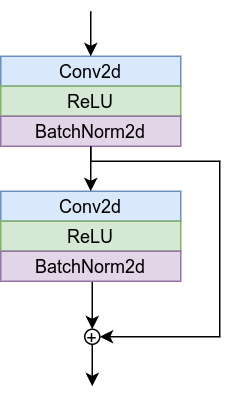

In [ ]:
class SkipBlock(nn.Module):
    def __init__(self, input_channels, output_channels):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(input_channels, output_channels, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(output_channels)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(output_channels, output_channels, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(output_channels)
        )

    def forward(self, x):
        # TODO: Use the layers as described in the diagram above to first
        #       make x2 equal the output of layer 1, then make x3 equal
        #       to the output of layer 2. Then implement the + operation
        #       at the end of the diagram somehow.
        # x2 = ...
        # x3 = ...
        # return ...

        # SOLUTION LINE
        x2 = self.layer1(x)
        # SOLUTION LINE
        x3 = self.layer2(x2)
        # SOLUTION LINE
        return x2 + x3

Note how the layers we used in the SkipBlock module don't have max-pooling, and that padding has been added.

The two tensors need to have the same shape to perform element-wise addition, thus it was necessary to remove max-pooling and add padding to the conv layers to ensure that the shapes don't change. As we still want max pooling, we will simply add this outside of the `SkipBlock`.

The code for a conv net using our new skip block has been implemented for you in the next cell. Read through it carefullly.

In [ ]:
class SkipConvNet(nn.Module):
    def __init__(self, device):
        super().__init__()
        # Use the new skip blocks
        self.feature_extractor = nn.Sequential(
            SkipBlock(1, 8),
            nn.MaxPool2d(2),
            SkipBlock(8, 16),
            nn.MaxPool2d(2),
            SkipBlock(16, 32),
            nn.MaxPool2d(2),
        )

        # As we added more layers and changed padding, the MLP has a different
        # input size
        self.mlp = MLP(device, 32*3*3)

        # Transfer the model weights to the GPU
        self.to(device)

    def forward(self, x):
        features = self.feature_extractor(x)
        return self.mlp(features)

That's the last model implementation done! Return to the "Train the Model" section and see how well this model performs now that we've made it deeper and added skip connections.

**Don't forget to use your new model by replacing BNConvNet with SkipConvNet!**

The results should be about the same as for the previous model.

#### Your Custom Model

What's the best model you can build? Design and implement a model using some of the ideas found at the end of the lab.

In [ ]:
class CustomModel(nn.Module):
    def __init__(self, device):
        # TODO: Initialise the layers
        self.to(device)

    def forward(self, x):
        # TODO: Use the layers
        return x

## Improve Performance
Now that you have all of these tools under your belt, see how well you can get the model to perform! How high can you get the test accuracy? By tweaking the model, optimiser, and number of training epochs, it's possible to achieve test accuracy of over `0.992`.

Here are a few ideas you can try to improve performance:
 * Make the model deeper with more layers
 * Change the size of the intermediate layers
 * Change the activation function
  * [Check out the PyTorch docs](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity) for a list of options. Common choices are ReLU, ELU, LeakyReLU, Sigmoid and Tanh.
 * Change the dropout percentage
 * Get creative with skip connections
 * Train for longer
 * Increase or decrease the learning rate

In [ ]:
# Code that can be used to empty the log file directory.
!rm -rf logs